# Fashion Mnist Model

# Importing Relevant Libraries

In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

from classification_models.tfkeras import Classifiers

from sklearn.metrics import confusion_matrix, classification_report

from albumentations import OneOf, Compose, HorizontalFlip, VerticalFlip
from albumentations.augmentations.transforms import (ToGray, CoarseDropout, GridDropout,
                                                     CLAHE, RandomContrast, RandomBrightness,
                                                     MultiplicativeNoise, ISONoise, OpticalDistortion, 
                                                     FancyPCA,MotionBlur,GaussianBlur)


2021-11-16 23:27:28.404048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Setup Default Configuration For Training

In [2]:
# Configuration
EPOCHS = 30

BATCH_SIZE = 128

IMAGE_SIZE = 64

IMAGE_BASE_SIZE = 28

SEED = 42

LR = 0.001

DATA_PATH = '../Data/fashion-mnist_train.csv'

TEST_PATH = '../Data/fashion-mnist_test.csv'

VERBOSE = 1

BACKBONE = 'resnet18'

FASHION_DICT = {0:'T-shirt/top',
                1:'Trouser',
                2:'Pullover',
                3:'Dress',
                4:'Coat',
                5:'Sandal',
                6:'Shirt',
                7:'Sneaker',
                8:'Bag',
                9:'Ankle boot'}

# Relevant functions for model and dataset preparation

In [3]:
#read train and test datasets
train = pd.read_csv(DATA_PATH)
test = pd.read_csv(TEST_PATH)

In [4]:
#create dataloader
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 df, 
                 
                 batch_size=BATCH_SIZE,
                 path=DATA_PATH, 
            
                 img_base_size = IMAGE_BASE_SIZE,
                 img_size=IMAGE_SIZE,
                 augment = False): 
        
        self.df = df
        
        self.indexes = np.arange(len(self.df))
        self.batch_size = batch_size
        self.path = path
        
        self.img_size = IMAGE_SIZE
        self.img_base_size = IMAGE_BASE_SIZE
        self.augment = augment
        self.augmentations = OneOf([HorizontalFlip(p=0.5), 
                                    VerticalFlip(p=0.5)
                                   ], p=0.5)
        
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        length = len(self.df) // self.batch_size
        if length%BATCH_SIZE==0:
            return length
        else:
            return length + 1
    

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generation(indexes)
        return X, Y
    

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X_images = np.zeros((len(indexes),self.img_size,self.img_size,1),dtype='float32')
        df = self.df.iloc[indexes].reset_index(drop=True)
        df_labels = df.iloc[:,0].values
        for i  in range(len(df)):
            img = df.iloc[i,1:].values.reshape(self.img_base_size,self.img_base_size)/255.
            img = cv2.resize(img,(self.img_size,self.img_size))
            if self.augment:
                img = self.augmentations(image = img.astype(np.float32))["image"]
            img = img[:,:,np.newaxis]
            X_images[i,] = img
        return X_images, df_labels



In [5]:
##Build the model
def make_model(base=BACKBONE, img_size = 64):
    model, preprocess_input = Classifiers.get(BACKBONE)
    resnet = model((img_size, img_size, 1), weights=None, include_top = False)
    
    bottle_neck = resnet.output
    top_layer = tf.keras.layers.GlobalAveragePooling2D(name='pool_layer')(bottle_neck)
    top_layer_classifier = tf.keras.layers.Dense(10, 
                                            activation = 'softmax', 
                                            name='emotions_output')(top_layer)
    
    
    model_ = Model(resnet.input, top_layer_classifier)
    
    opt = Adam(lr = LR)

    model_.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
        )
    
    return model_

# Train and Validate

In [6]:
#clear GPU memory
tf.keras.backend.clear_session()

#Build the model
model = make_model();

#Prepare train and test data generators
train_gen = DataGenerator(train, augment=True)
test_gen = DataGenerator(test, augment=False)


#Add callbacks
early_stopping = EarlyStopping(monitor= 'val_sparse_categorical_accuracy', mode = 'max',patience=5, verbose=1)


model_checkpoint = ModelCheckpoint('./ckpt/{}_FASHION_MNIST.h5'.format(BACKBONE),
                                   monitor = 'val_sparse_categorical_accuracy', 
                                   mode = 'max', 
                                   save_best_only=True, 
                                   save_weights_only = True, 
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', 
                              mode = 'max',
                              factor=0.5, 
                              patience=2, 
                              min_lr=0.00000001, 
                              verbose=1)
    
csv_logger = tf.keras.callbacks.CSVLogger('./training_logs/training_logs.csv')

callbacks = [early_stopping, 
             model_checkpoint, 
             reduce_lr, 
             csv_logger]


#Train the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    epochs = EPOCHS,
                    callbacks = callbacks);

2021-11-16 23:27:33.582098: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-16 23:27:33.583168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-16 23:27:33.650383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6575GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-11-16 23:27:33.650436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-16 23:27:33.652094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-16 23:27:33.652163: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10


Epoch 1/30


2021-11-16 23:27:36.311642: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-16 23:27:36.457308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


469/469 [==============================] - 30s 59ms/step - loss: 0.5745 - sparse_categorical_accuracy: 0.7890 - val_loss: 0.3923 - val_sparse_categorical_accuracy: 0.8621

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.86210, saving model to ./ckpt/resnet18_FASHION_MNIST.h5
Epoch 2/30
469/469 [==============================] - 27s 57ms/step - loss: 0.3071 - sparse_categorical_accuracy: 0.8881 - val_loss: 0.2602 - val_sparse_categorical_accuracy: 0.9077

Epoch 00002: val_sparse_categorical_accuracy improved from 0.86210 to 0.90770, saving model to ./ckpt/resnet18_FASHION_MNIST.h5
Epoch 3/30
469/469 [==============================] - 26s 56ms/step - loss: 0.2619 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 0.9063

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.90770
Epoch 4/30
469/469 [==============================] - 27s 58ms/step - loss: 0.2280 - sparse_categorical_accuracy: 0.9155 - val_loss: 0.

In [7]:
#saving training history for later use
with open("./training_logs/training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Model Validation Accuracy summary Plot

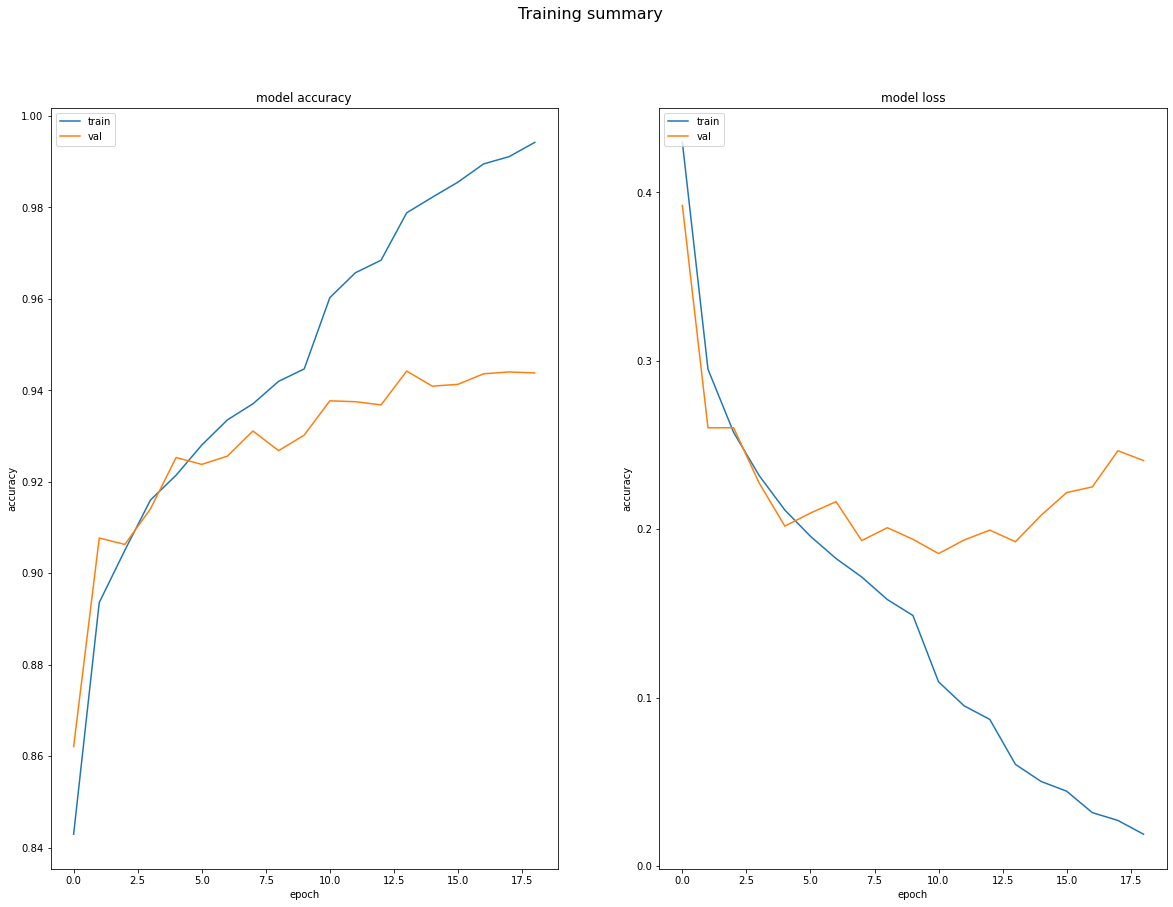

In [8]:
def plot_history(hist):
    fig, axs = plt.subplots(1, 2,figsize=(20,14))
    axs[0].plot(hist['sparse_categorical_accuracy'])
    axs[0].plot(hist['val_sparse_categorical_accuracy'])
    axs[0].legend(['train', 'val'], loc='upper left')
    axs[0].set_title('model accuracy')


    axs[1].plot(hist['loss'])
    axs[1].plot(hist['val_loss'])
    axs[1].legend(['train', 'val'], loc='upper left')
    axs[1].set_title('model loss')

    fig.suptitle('Training summary', fontsize=16)

    for ax in axs.flat:
        ax.set(xlabel='epoch', ylabel='accuracy')
        
    plt.show()

plot_history(history.history)

# Evaluate Test confusion matrix

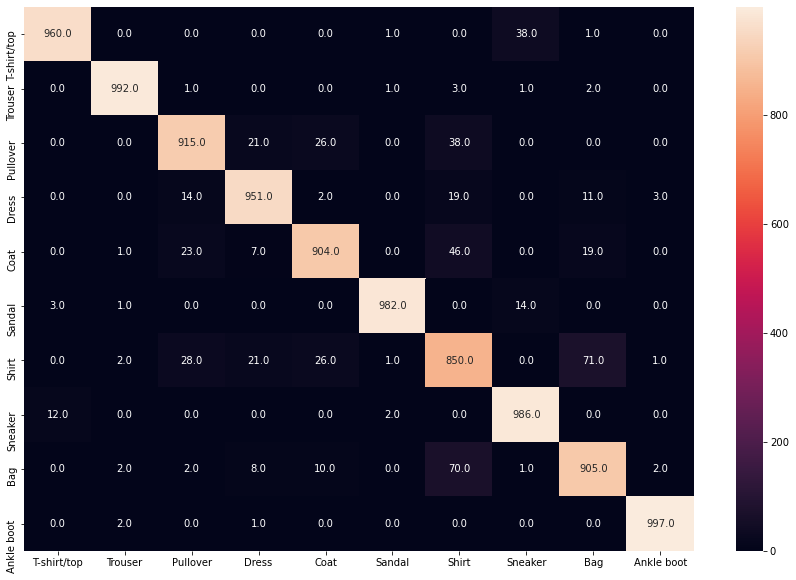

In [9]:
#Select Best Checkpoint
model.load_weights('./ckpt/{}_FASHION_MNIST.h5'.format(BACKBONE))

preds = np.argmax(model.predict(test_gen), axis=-1)
y_pred = [FASHION_DICT[x] for x in preds]
y_true = test.label.map(lambda x: FASHION_DICT[x]).tolist()

cm = confusion_matrix(y_true, y_pred)
fashions = list(FASHION_DICT.values())
df_cm = pd.DataFrame(cm, fashions, fashions)

plt.figure(figsize = (15,10))
sns.heatmap(df_cm, annot=True, fmt='.1f');

# Evaluate Test results per class

In [10]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

  Ankle boot       0.98      0.96      0.97      1000
         Bag       0.99      0.99      0.99      1000
        Coat       0.93      0.92      0.92      1000
       Dress       0.94      0.95      0.95      1000
    Pullover       0.93      0.90      0.92      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.83      0.85      0.84      1000
     Sneaker       0.95      0.99      0.97      1000
 T-shirt/top       0.90      0.91      0.90      1000
     Trouser       0.99      1.00      1.00      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

